# Simple line fit with MCMC

In [1]:
from __future__ import print_function, division
import pylab as pl
import  corner
import emcee
import scipy
from scipy.stats import norm as spnorm

%pylab inline

pl.rcParams['figure.figsize']= (10,10)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def line(m, b, x):
    return m * x + b

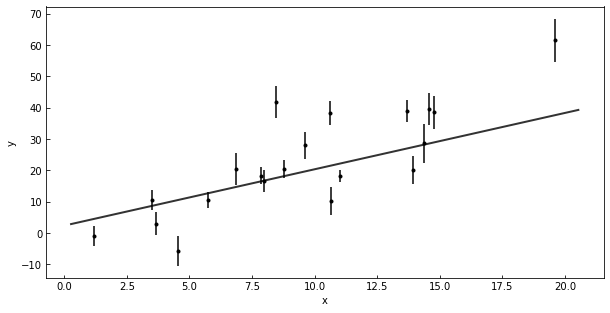

In [3]:
# Choose the "true" parameters.
m_true = 1.8
b_true = 2.3

# Generate some synthetic data from the model.
N = 20
np.random.seed(123)
x = np.sort(np.random.rand(N) * 20)
y = line(m_true, b_true, x)
yerr = np.sqrt(y) + np.random.randn(N) 
y += yerr * np.random.randn(N) * 2

ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.errorbar(x, y, yerr=yerr, fmt='k.')
ax.plot(pl.xlim(), line(m_true, b_true,  np.array(pl.xlim())), 'k-', alpha=0.8, lw=2)

To get 

$P(\theta \mid D,f)$

from Bayes theorem

$P(\theta \mid D,f)\quad \propto { { \quad P(D\mid \theta ,f)\, P(\theta ,f) } } $

I need $ { { \quad P(D\mid \theta ,f)\, P(\theta ,f) } } $ 

NEXT STEP: define Prior $ P(\theta ,f)$ and Likelihood $\quad P(D\mid \theta ,f)$

# prior

In [4]:
# what do I know about my model? the slope should be between 0 and 90 degree
def lnprior(theta):
    m, b = theta
    if -10 < b < 10 and 0 < m < 10 :
        return 0.0
    return -np.inf

# likelihood

In [5]:
#remember the chi square: 
# Sum((model - data)/error)^2 is a quantity that follows a chi square distribution with N=number of degreed of freedom. 
# Divide it by the number of degreed  of freedom as Chisq = (Sum((model - data)/error)^2)/DOF
# If it is ~1 that is a good model. 
# >1 bad model
# <1 your errors must be underestimated (model too good to be true!)

def lnlike(theta, x, y, yerr):
    m, b = theta
    return -0.5*(np.sum((line(m, b, x) - y)**2 / (yerr**2)))

# DYI Metropolis Hasting 

In [6]:
np.random.seed(666)

theta_current = (m_true, b_true) + np.random.randn(2)

# we start the walk here
walk = [theta_current]

# propoed perturbation of the current position - gaussian with width 0.5
proposal_width = (0.2, 0.2) 
proposal = spnorm(theta_current, proposal_width).rvs()

# current values  of the pieces of Bayes theorem
ln_current = lnlike(theta_current, x, y, yerr)
prior_current = lnprior(theta_current)

# values  of the pieces of Bayes theorem at the proposed position
ln_proposal  = lnlike(proposal, x, y, yerr)
prior_proposal = lnprior(proposal)

# put them together
p_current = np.exp(ln_current + prior_current)
p_proposal = np.exp(ln_proposal + prior_proposal)


In [7]:
# move along the walk N = 100, 1000 steps
np.random.seed(666)

theta_current = (m_true, b_true) + np.random.randn(2)

# we start the walk here
walk = [theta_current]

# propoed perturbation of the current position - gaussian with width 0.5
proposal_width = (0.2, 0.2) 
proposal = spnorm(theta_current, proposal_width).rvs()

# current values  of the pieces of Bayes theorem
ln_current = lnlike(theta_current, x, y, yerr)
prior_current = lnprior(theta_current)

# values  of the pieces of Bayes theorem at the proposed position
ln_proposal  = lnlike(proposal, x, y, yerr)
prior_proposal = lnprior(proposal)

# put them together
p_current = np.exp(ln_current + prior_current)
p_proposal = np.exp(ln_proposal + prior_proposal)

for i in range(10000):
    
    # calculate the proposal and the prior  and likelihood there
    proposal = spnorm(theta_current, proposal_width).rvs()
    ln_proposal  = lnlike(proposal, x, y, yerr)
    prior_proposal = lnprior(proposal)
    p_proposal = np.exp(ln_proposal + prior_proposal)
    
    # update for sure if it is a better location
    if p_proposal > p_current:
        #print ("right away")
        theta_current, ln_current, prior_current, p_current = \
        proposal, ln_proposal, prior_proposal, p_proposal
        walk.append(proposal)
        
    #update with a probability equal to the posteriors ratio if the location is worse
    else:
        p_accept = (p_proposal / p_current)
        
        #use a stocastic draw to accept with probability P
        if np.random.rand() < p_accept:
            #print ("later on away")

            theta_current, ln_current, prior_current, p_current = proposal, ln_proposal, prior_proposal, p_proposal
            walk.append(proposal)
        

[ 2.69298262  2.51979836  2.83649117] [-4.42254874 -5.57987424 -2.79124383]


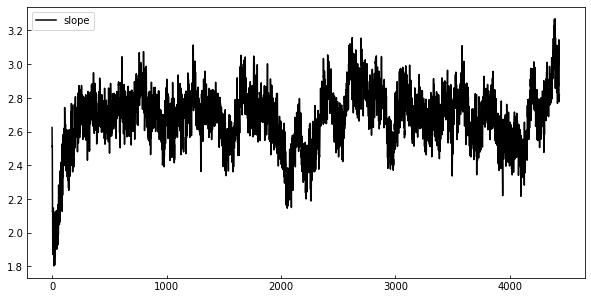

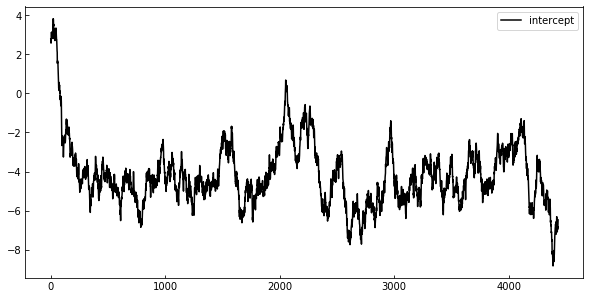

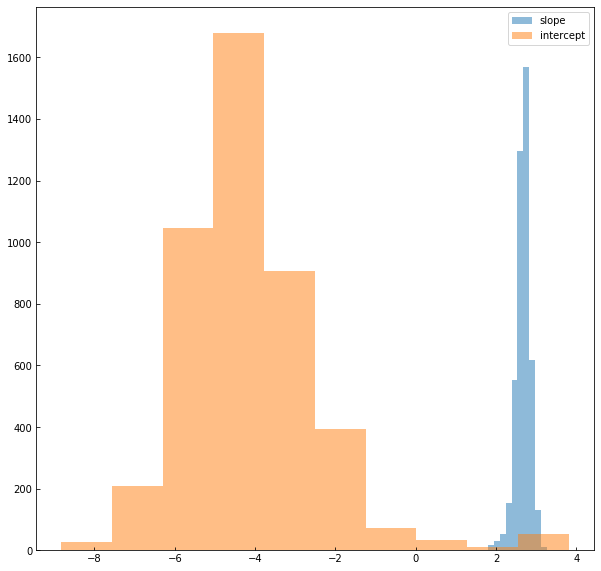

In [46]:
# look at the sampled posterior  space
pl.figure(figsize=(10,5))
pl.plot(np.array(walk)[:,0],'k-', label="slope")
pl.legend()

pl.figure(figsize=(10,5))
pl.plot(np.array(walk)[:,1], 'k-', label="intercept")
pl.legend()

pl.figure()
pl.hist(np.array(walk)[:,0], alpha=0.5, label="slope")

pl.hist(np.array(walk)[:,1], alpha=0.5, label="intercept")
pl.legend()

print (np.percentile(np.array(walk)[:,0], [50, 16, 84]), 
       np.percentile(np.array(walk)[:,1], [50, 16, 84]))

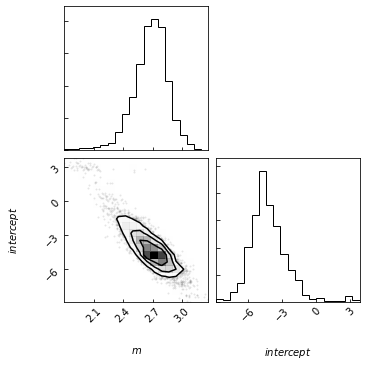

In [9]:
fig = corner.corner(walk, labels=["$m$","$intercept$"])

# Affine Invariant MCMC sample (with emcee)

In [29]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [30]:
ndim, nwalkers = 2, 100
pos = [np.array([m_true, b_true]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, 500);

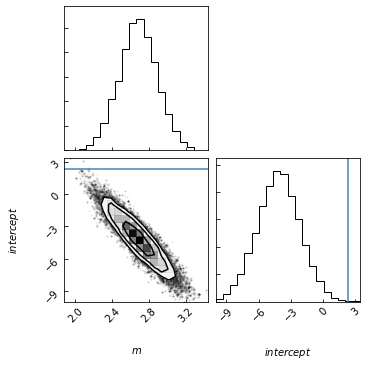

In [31]:
samples = sampler.chain[:, 150:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m$","$intercept$"],
                      truths=[m_true, b_true])

In [32]:
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [33]:
m_mcmc, b_mcmc

((2.6791620068082804, 0.20707404899356119, 0.20642527638822372),
 (-4.1403279936776807, 1.9376566120831389, 1.99027543219003))

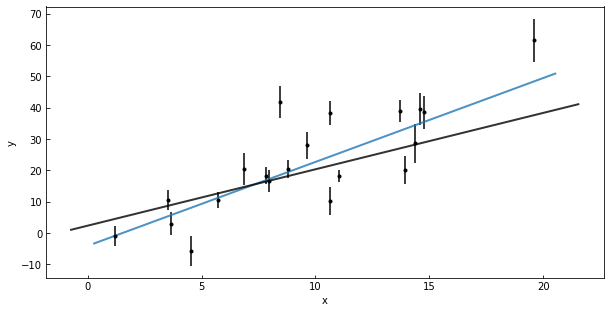

In [34]:
ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.errorbar(x, y, yerr=yerr, fmt='k.')
ax.plot(pl.xlim(), line(m_mcmc[0], b_mcmc[0],  np.array(pl.xlim())), '-', alpha=0.8, lw=2)
ax.plot(pl.xlim(), line(m_true, b_true,  np.array(pl.xlim())), 'k-', alpha=0.8, lw=2)

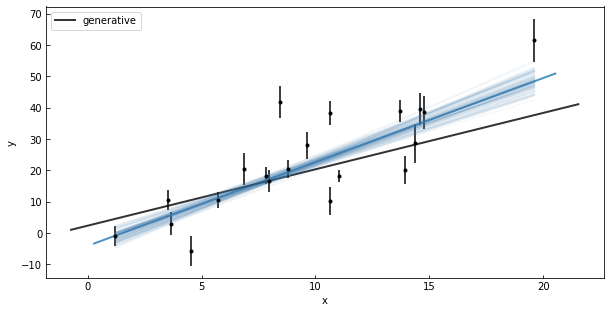

In [35]:
ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.errorbar(x, y, yerr=yerr, fmt='k.')
ax.plot(pl.xlim(), line(m_mcmc[0], b_mcmc[0],  np.array(pl.xlim())), '-', alpha=0.8, lw=2)
ax.plot(pl.xlim(), line(m_true, b_true,  np.array(pl.xlim())), 'k-', 
        alpha=0.8, lw=2, label="generative")
for m, b in samples[np.random.randint(len(samples), size=100)]:
    ax.plot(x, m*x+b, color="SteelBlue", alpha=0.05)
ax.legend(loc=2);

In [36]:
# linear algebra solution
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

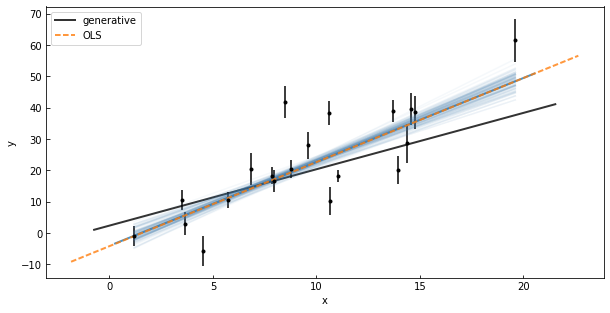

In [37]:
ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.errorbar(x, y, yerr=yerr, fmt='k.')
ax.plot(pl.xlim(), line(m_mcmc[0], b_mcmc[0],  np.array(pl.xlim())), '-', alpha=0.8, lw=2)
ax.plot(pl.xlim(), line(m_true, b_true,  np.array(pl.xlim())), 'k-',
        alpha=0.8, lw=2, label="generative")
for m, b in samples[np.random.randint(len(samples), size=100)]:
    ax.plot(x, m*x+b, color="SteelBlue", alpha=0.05)
ax.plot(pl.xlim(), line(m_ls, b_ls,  np.array(pl.xlim())), '--', 
        alpha=0.8, lw=2, label="OLS")
pl.legend();

In [38]:
ndim, nwalkers = 2, 100
pos = [np.array([m_ls, b_ls]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, 500);

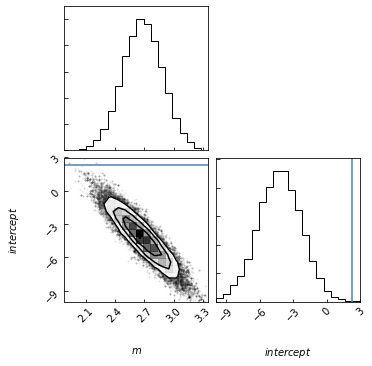

In [39]:
samples = sampler.chain[:, 150:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m$","$intercept$"],
                      truths=[m_true, b_true])

In [40]:
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
m_mcmc, b_mcmc

((2.6800569984768536, 0.20833284208782787, 0.20398688613869753),
 (-4.2245649727720291, 1.9203662477926362, 1.9336543832136632))

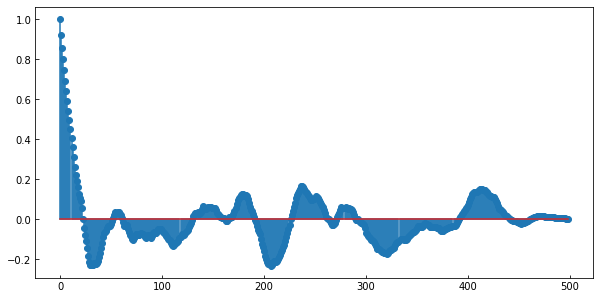

In [41]:
def acorr(x):
    ax = pl.figure(figsize=(10,5)).add_subplot(111)

    x = x - x.mean()

    autocorr = np.correlate(x, x, mode='full')
    autocorr = autocorr[x.size:]
    autocorr /= autocorr.max()

    return ax.stem(autocorr)

acorr(sampler.chain[0,:,0])
pl.show()


In [42]:
ndim, nwalkers = 2, 100
pos = [np.array([m_ls, b_ls]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, 1500);

<Container object of 3 artists>

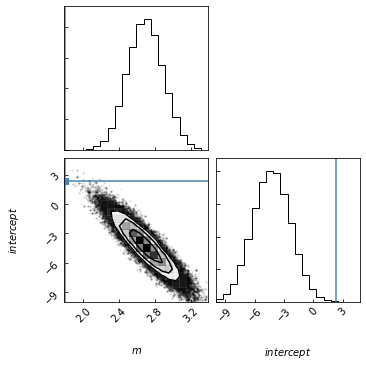

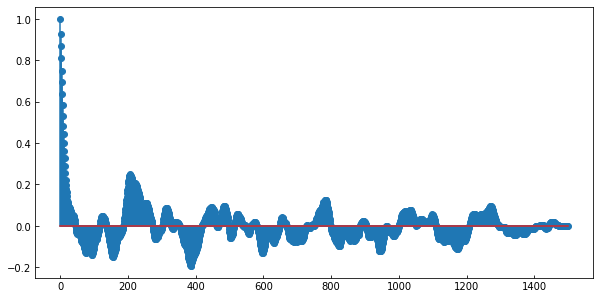

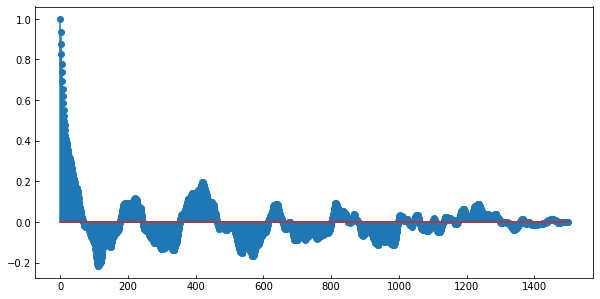

In [44]:
samples = sampler.chain[:, 150:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m$","$intercept$"],
                      truths=[m_true, b_true])
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
m_mcmc, b_mcmc

acorr(sampler.chain[0,:,0])

acorr(sampler.chain[1,:,0])
